<a href="https://colab.research.google.com/github/ikanx101/Workshop-Astra-Financial/blob/main/Workshop%20FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analisa Data Transaksi**

Pada _workshop_ kali ini, kami akan memberikan contoh data transaksi yang didapatkan dari sistem CRM suatu minimarket di kota tertentu sejak bulan Januari 2020 hingga April 2020. Minimarket tersebut sudah terbiasa melakukan evaluasi performa setiap _quarter_.

Kita akan membuat dua analisa sederhana dari data ini, yakni:

- _Clustering_ pelanggan yang menjadi _member_.
- Membuat promo produk _bundling_.

Untuk melakukan analisa, akan ada empat tahap pengerjaan, yakni:

1. _Pre processing_ dengan menggabungkan empat data transaksi bulanan menjadi satu _dataframe_.
1. _Exploratory data analysis_ dengan membuat tabulasi dan visualisasi sederhana dari data tersebut.
1. _Clustering_ konsumen berdasarkan _framework_ __RFM__ (_retention_, _frequency_, dan _monetary_) dari masing-masing konsumen. Kelak akan didiskusikan strategi / _campaign marketing_ apa saja yang bisa kita berikan kepada masing-masing _cluster_ (kelompok) konsumen.
1. _Cross basket analysis_ untuk menganalisa dan memberikan saran produk apa saja yang bisa dijual berbarengan (_cross selling_ / _upselling_). Kita akan diskusikan juga nanti saat _workshop_.

## **Tahap I** _Pre Processing_

Pada tahap ini, kita akan _import_ semua data transaksi bulanan (format `.csv`) ke dalam _computing environment_).

In [ ]:
# Menghapus semua objek dari lingkungan saat ini
rm(list=ls())
# Memanggil garbage collector untuk mengklaim kembali memori yang tidak terpakai
gc()
set.seed(17081945)

# memanggil semua libraries yang diperlukan
# dplyr: menyediakan fungsi-fungsi untuk manipulasi data (e.g., filter, select, mutate).
library(dplyr)
# tidyr: menyediakan fungsi-fungsi untuk merapikan data (e.g., gather, spread).
library(tidyr)
# janitor: library untuk memberishkan data dan membuat tabulasi sederhana
# install.packages("janitor")
library(janitor)
# ggplot2: membuat visualisasi data
library(ggplot2)
# untuk clustering
library(cluster)
# untuk clustering
# install.packages("factoextra")
library(factoextra)
# arules: untuk keperluan algoritma apriori
# install.packages("arules")
library(arules)
# arulesViz: untuk keperluan visualisasi hasil algoritma apriori
# install.packages("arulesViz")
library(arulesViz)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2737668,146.3,4540041,242.5,4540041,242.5
Vcells,4811054,36.8,10146329,77.5,9193401,70.2


In [ ]:
# kita akan panggil semua data csv transaksi per bulan
df_1 = read.csv("jan 2020.csv")
df_2 = read.csv("feb 2020.csv")
df_3 = read.csv("mar 2020.csv")
df_4 = read.csv("apr 2020.csv")

# Menggabungkan semua data transaksi
df_all =
  data.table::rbindlist(list(df_1,df_2,df_3,df_4)) |>  # Menggabungkan data frame menggunakan rbindlist
  as.data.frame() |>  # Mengubah hasil rbindlist menjadi data frame
  select(-id) |> # Menghapus kolom X dan id
  mutate(tanggal = as.Date(tanggal,"%Y-%m-%d")) |> # Mengubah kolom tanggal menjadi tipe data Date
  mutate(bulan = months(tanggal)) |> # Membuat kolom baru "bulan" berdasarkan nilai kolom "tanggal"
  mutate(bulan = factor(bulan,levels = c("January","February","March","April"))) |> # membuat nama bulan jadi factor
  select(id_transaksi,tanggal,bulan,hari,jam,ampm,id_pelanggan,sku,qty,unit,harga,diskon,total_harga) # Memilih kolom-kolom yang ingin disertakan dalam data frame akhir

In [ ]:
# Melihat struktur data frame df_all
df_all |> str()

'data.frame':	34436 obs. of  13 variables:
 $ id_transaksi: chr  "00001/KSR/UTM/0120" "00001/KSR/UTM/0120" "00001/KSR/UTM/0120" "00010/KSR/UTM/0120" ...
 $ tanggal     : Date, format: "2020-01-02" "2020-01-02" ...
 $ bulan       : Factor w/ 4 levels "January","February",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ hari        : chr  "4 Kamis" "4 Kamis" "4 Kamis" "4 Kamis" ...
 $ jam         : int  8 8 8 9 9 9 9 9 9 9 ...
 $ ampm        : chr  "1 pagi" "1 pagi" "1 pagi" "1 pagi" ...
 $ id_pelanggan: chr  "UMUM" "UMUM" "UMUM" "17114227" ...
 $ sku         : chr  "KOPIKO COFFE LATTE 240 ML" "INDOMIE GORENG 85G" "INDOMIE GORENG SPECIAL JUMBO 125 GR" "212 AIR MINERAL 48 X 240 ML" ...
 $ qty         : int  1 1 1 4 4 1 1 1 2 1 ...
 $ unit        : chr  "PCS" "PCS" "PCS" "DUS" ...
 $ harga       : num  5400 2500 3500 22000 64000 11200 10600 6700 3700 11300 ...
 $ diskon      : num  0 0 0 0 3.44 ...
 $ total_harga : num  5400 2500 3500 88000 247200 ...


Berikut adalah penjelasan beberapa variabel dari data yang sudah digabung:

- `id_transaksi`: __id__ dari satu transaksi.
- `tanggal`: tanggal transaksi.
- `id_pelanggan`: merupakan __id__ pelanggan. Pelanggan yang menjadi _member_ akan ditulis nomor _membership_-nya. Sedangkan pelanggan yang _non member_ ditulis sebagai __UMUM__.
- `sku`: merupakan nama produk yang dibeli.
- `diskon`: merupakan diskon produk dalam __persentase__.
- `total_harga`: merupakan harga total per `sku` yang merupakan perkalian dari `qty` dengan `harga` setelah dikurang `diskon`.

## **Tahap II** _Exploratory Data Analysis_

Sekarang kita akan buat EDA sederhana dari data gabungan yang ada.

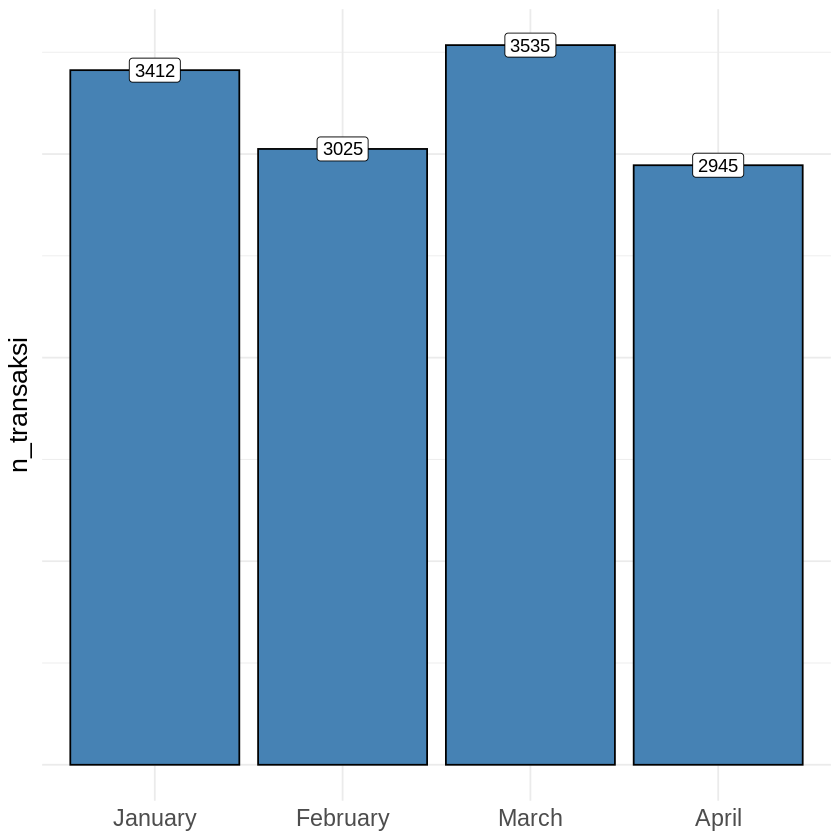

In [ ]:
# perhitungan berapa banyak transaksi per bulan
df_all |>
  group_by(bulan) |>
  summarise(n_transaksi = length(unique(id_transaksi))) |>
  ungroup() |>
  ggplot(aes(x = bulan,y = n_transaksi)) +
  geom_col(color = "black",fill = "steelblue") +
  geom_label(aes(label = n_transaksi)) +
  theme_minimal() +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 16),
        axis.text.y = element_blank(),
        axis.text.x = element_text(size = 14))

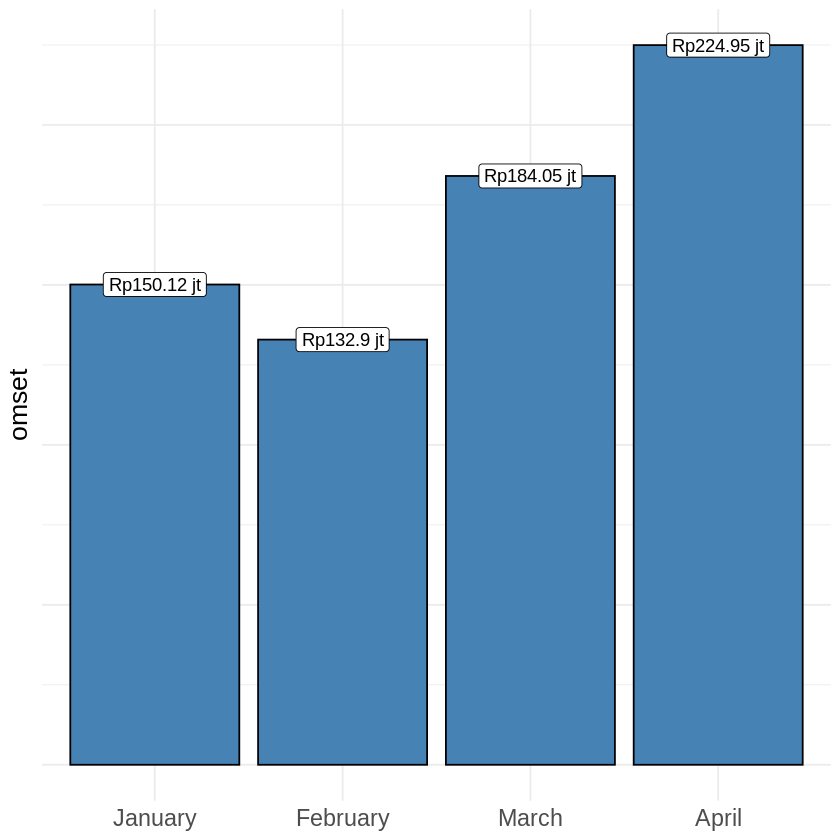

In [ ]:
# perhitungan berapa besar omset per bulan
df_all |>
  group_by(bulan) |>
  summarise(omset = sum(total_harga)) |>
  ungroup() |>
  mutate(label = omset / 1000000,
         label = round(label,2),
         label = paste0("Rp",label," jt")) |>
  ggplot(aes(x = bulan,y = omset)) +
  geom_col(color = "black",fill = "steelblue") +
  geom_label(aes(label = label)) +
  theme_minimal() +
  theme(axis.title.x = element_blank(),
        axis.title.y = element_text(size = 16),
        axis.text.y = element_blank(),
        axis.text.x = element_text(size = 14))

`summarise()` has grouped output by 'hari'. You can override using the
`.groups` argument.


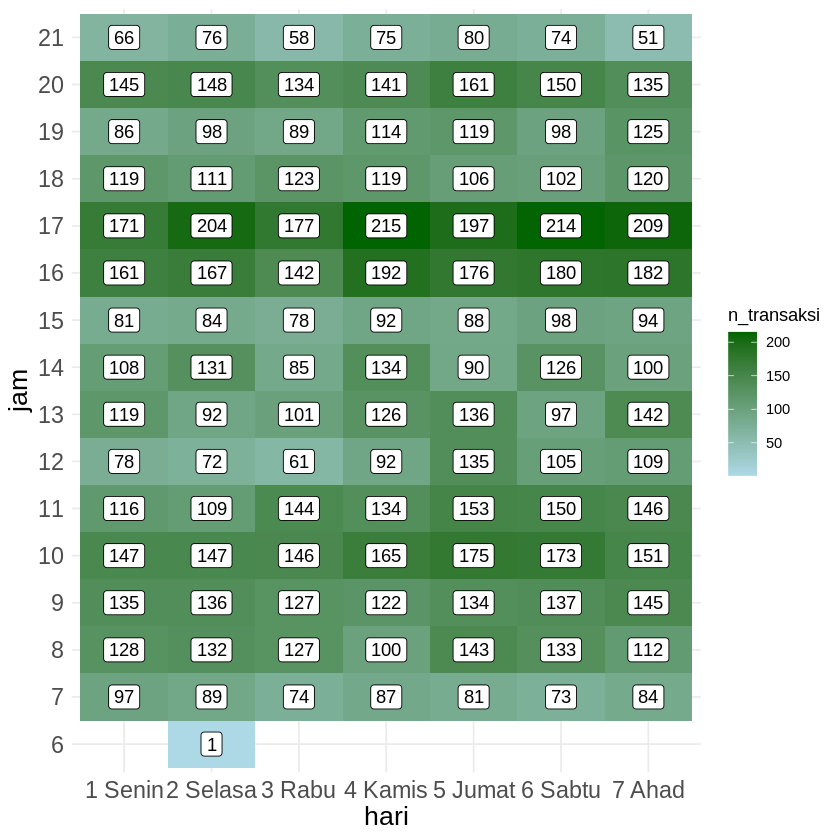

In [ ]:
# waktu paling ramai di minimarket
df_all |>
  group_by(hari,jam) |>
  summarise(n_transaksi = length(unique(id_transaksi))) |>
  ungroup() |>
  mutate(jam = factor(jam)) |>
  ggplot(aes(x = hari,y = jam)) +
  geom_tile(aes(fill = n_transaksi)) +
  scale_fill_gradient(high = "darkgreen",low = "lightblue") +
  geom_label(aes(label = n_transaksi)) +
  theme_minimal() +
  theme(axis.title = element_text(size = 16),
        axis.text  = element_text(size = 14))

Selain tiga grafik di atas, EDA apa lagi yang bisa kita lakukan? Silakan buat sebagai bahan latihan.

## **Tahap III** _Clustering Analysis_ berdasarkan RFM

Pada analisa ini, __kita hanya akan memakai data transaksi dari pelanggan yang menjadi__ ___member___. Sehingga akan ada proses _filtering_ data.

__Definisi:__

- _Retention_ adalah kapan terakhir kali pelanggan bertransaksi pada rentang Januari 2020 sampai April 2020.
- _Frequency_ adalah berapa kali pelanggan bertransaksi pada rentang Januari 2020 sampai April 2020.
- _Monetary_ adalah seberapa besar (secara _value_ rupiah) pelanggan berbelanja pada rentang Januari 2020 sampai April 2020.

Kita akan menghitung ketiga parameter tersebut dengan aturan sebagai berikut:

1. Semua parameter memiliki nilai skala 1-4 (paling rendah ke paling tinggi).
1. _Retention_: pelanggan yang terakhir kali membeli pada:
    - _April_ mendapat skor 4.
    - _March_ mendapat skor 3.
    - _February_ mendapat skor 2.
    - _January_ mendapat skor 1.
1. _Frequency_: kita akan hitung rata-rata transaksi bulanan untuk setiap pelanggan. Kemudian dari semua data yang ada, kita akan bagi menjadi __empat__ kelompok berdasarkan _range_ datanya.
1. Monetary: Kita akan hitung rata-rata belanja bulanan untuk setiap pelanggan. Kemudian dari semua data yang ada, kita akan bagi menjadi __empat__ kelompok berdasarkan _range_ datanya.

In [ ]:
df_all |> str()

'data.frame':	34436 obs. of  13 variables:
 $ id_transaksi: chr  "00001/KSR/UTM/0120" "00001/KSR/UTM/0120" "00001/KSR/UTM/0120" "00010/KSR/UTM/0120" ...
 $ tanggal     : Date, format: "2020-01-02" "2020-01-02" ...
 $ bulan       : Factor w/ 4 levels "January","February",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ hari        : chr  "4 Kamis" "4 Kamis" "4 Kamis" "4 Kamis" ...
 $ jam         : int  8 8 8 9 9 9 9 9 9 9 ...
 $ ampm        : chr  "1 pagi" "1 pagi" "1 pagi" "1 pagi" ...
 $ id_pelanggan: chr  "UMUM" "UMUM" "UMUM" "17114227" ...
 $ sku         : chr  "KOPIKO COFFE LATTE 240 ML" "INDOMIE GORENG 85G" "INDOMIE GORENG SPECIAL JUMBO 125 GR" "212 AIR MINERAL 48 X 240 ML" ...
 $ qty         : int  1 1 1 4 4 1 1 1 2 1 ...
 $ unit        : chr  "PCS" "PCS" "PCS" "DUS" ...
 $ harga       : num  5400 2500 3500 22000 64000 11200 10600 6700 3700 11300 ...
 $ diskon      : num  0 0 0 0 3.44 ...
 $ total_harga : num  5400 2500 3500 88000 247200 ...


In [ ]:
# mengambil data yang khusus untuk RFM
# Memfilter data df_all untuk hanya menyertakan pelanggan yang merupakan member (id_pelanggan != "UMUM")
df_rfm =
  df_all |>
  filter(id_pelanggan != "UMUM")

# perhitungan retention
# Menghitung skor retention berdasarkan bulan terakhir transaksi
df_rfm_1 =
  df_rfm |>
  # Membuat kolom baru 'retention' dengan skor 1-4 berdasarkan bulan transaksi
  mutate(retention = case_when(
    bulan == "January" ~ 1, # Jika bulan transaksi Januari, skor retention = 1
    bulan == "February" ~ 2, # Jika bulan transaksi Februari, skor retention = 2
    bulan == "March" ~ 3, # Jika bulan transaksi Maret, skor retention = 3
    bulan == "April" ~ 4 # Jika bulan transaksi April, skor retention = 4
  )) |>
  # Memilih kolom id_pelanggan dan retention
  select(id_pelanggan,retention) |>
  # Menghapus baris duplikat berdasarkan kombinasi id_pelanggan dan retention
  distinct() |>
  # Mengelompokkan data berdasarkan id_pelanggan
  group_by(id_pelanggan) |>
  # Memfilter data untuk setiap pelanggan, hanya mempertahankan baris dengan skor retention tertinggi
  filter(retention == max(retention)) |>
  # Menghilangkan pengelompokan
  ungroup()


# perhitungan frekuensi
# Menghitung frekuensi transaksi per pelanggan
df_rfm_2 =
  df_rfm |>
  # Mengelompokkan data berdasarkan id_pelanggan
  group_by(id_pelanggan) |>
  # Menghitung jumlah transaksi unik per pelanggan dan menyimpannya di kolom 'freq'
  summarise(freq = length(unique(id_transaksi))) |>
  # Menghilangkan pengelompokan
  ungroup() |>
  # Menghitung rata-rata frekuensi transaksi bulanan dengan membagi 'freq' dengan 4 (jumlah bulan)
  mutate(freq = freq / 4) |>
  # Memilih kolom id_pelanggan dan freq
  select(id_pelanggan,freq) |>
  mutate(freq = cut(freq,4,labels = 1:4),
         freq = as.numeric(freq))

# perhitungan monetary
# Menghitung total nilai transaksi (monetary) per pelanggan
df_rfm_3 =
  df_rfm |>
  # Mengelompokkan data berdasarkan id_pelanggan
  group_by(id_pelanggan) |>
  # Menghitung total nilai transaksi per pelanggan dan menyimpannya di kolom 'monetary'
  summarise(monetary = sum(total_harga)) |>
  # Menghilangkan pengelompokan
  ungroup() |>
  # Menghitung rata-rata nilai transaksi bulanan dengan membagi 'monetary' dengan 4 (jumlah bulan)
  mutate(monetary = monetary / 4) |>
  # Memilih kolom id_pelanggan dan monetary
  select(id_pelanggan,monetary) |>
  mutate(monetary = cut(monetary,4,labels = 1:4),
         monetary = as.numeric(monetary))

# Menampilkan struktur data dari df_rfm_1, df_rfm_2, dan df_rfm_3
str(df_rfm_1)
str(df_rfm_2)
str(df_rfm_3)

# Menggabungkan data frame df_rfm_1, df_rfm_2, dan df_rfm_3 menjadi satu data frame df_rfm_all
df_rfm_all =
  merge(df_rfm_1,df_rfm_2) |> # Menggabungkan df_rfm_1 dan df_rfm_2 berdasarkan kolom 'id_pelanggan'
  merge(df_rfm_3) # Menggabungkan hasil penggabungan sebelumnya dengan df_rfm_3 berdasarkan kolom 'id_pelanggan'

# Menskalakan data RFM menggunakan fungsi scale()
df_rfm_all_scaled = df_rfm_all |> select(-id_pelanggan)

tibble [131 × 2] (S3: tbl_df/tbl/data.frame)
 $ id_pelanggan: chr [1:131] "17114230" "17114135" "17114011" "17114104" ...
 $ retention   : num [1:131] 1 2 2 2 2 2 2 2 2 3 ...
tibble [131 × 2] (S3: tbl_df/tbl/data.frame)
 $ id_pelanggan: chr [1:131] "17114001" "17114002" "17114003" "17114004" ...
 $ freq        : num [1:131] 1 1 2 1 1 1 1 1 1 1 ...
tibble [131 × 2] (S3: tbl_df/tbl/data.frame)
 $ id_pelanggan: chr [1:131] "17114001" "17114002" "17114003" "17114004" ...
 $ monetary    : num [1:131] 1 1 2 1 1 1 1 1 1 1 ...


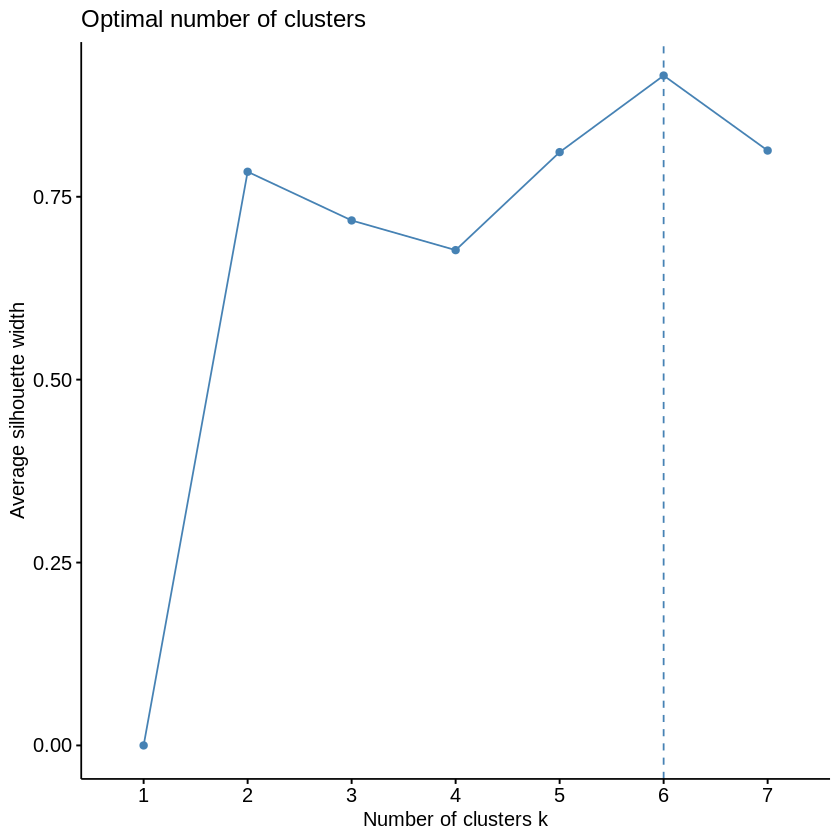

In [ ]:
# Menentukan rentang jumlah cluster (k) yang akan diuji, dari 2 hingga 7
k_range <- 2:7

# Menghitung rata-rata lebar silhouette untuk setiap nilai k
avg_sil_widths <- sapply(k_range, function(k) { # Melakukan iterasi untuk setiap nilai k dalam k_range
  kmeans_result <- kmeans(df_rfm_all_scaled, centers = k,iter.max = 50) # Melakukan clustering k-means dengan k cluster
  sil <- silhouette(kmeans_result$cluster, dist(df_rfm_all_scaled)) # Menghitung silhouette score untuk setiap data point
  mean(sil[, 3]) # Menghitung rata-rata silhouette score untuk semua data point (kolom 3 dari objek silhouette)
})

# Menentukan jumlah cluster optimal (k) yang menghasilkan rata-rata lebar silhouette tertinggi
optimal_k <- k_range[which.max(avg_sil_widths)] # Mencari indeks k dengan nilai avg_sil_widths maksimum dan mengambil nilai k yang sesuai

# Membuat visualisasi untuk menentukan jumlah cluster optimal menggunakan metode silhouette
fviz_nbclust(df_rfm_all_scaled, kmeans, method = "silhouette",  # Menggunakan fungsi fviz_nbclust dari package factoextra
             k.max = 7)  # Menentukan jumlah maksimum cluster yang akan divisualisasikan (k.max = 7)

In [ ]:
# Melakukan clustering K-means pada data RFM yang telah diskalakan
kmeans_result <- kmeans(df_rfm_all_scaled, centers = optimal_k,iter.max = 50)
# df_rfm_all_scaled: Data RFM yang telah diskalakan, digunakan sebagai input untuk clustering
# centers = optimal_k: Menentukan jumlah cluster yang digunakan dalam K-means, diambil dari nilai optimal_k yang telah dihitung sebelumnya

# Menampilkan hasil clustering K-means
kmeans_result
# Menampilkan objek kmeans_result yang berisi informasi tentang hasil clustering,
# seperti cluster setiap data point, centroid cluster, dan statistik lainnya.

K-means clustering with 6 clusters of sizes 97, 4, 3, 7, 19, 1

Cluster means:
  retention     freq monetary
1  4.000000 1.000000     1.00
2  4.000000 3.750000     2.25
3  4.000000 1.333333     2.00
4  4.000000 2.142857     1.00
5  2.473684 1.000000     1.00
6  4.000000 2.000000     4.00

Clustering vector:
  [1] 1 5 3 5 1 1 1 1 5 1 5 1 4 1 1 1 2 1 1 1 1 1 1 1 3 1 5 1 5 1 1 1 1 1 1 4 1
 [38] 1 5 1 1 1 1 1 1 1 1 5 1 1 4 1 1 1 1 1 5 1 5 1 1 1 1 1 2 2 5 1 4 1 1 1 1 1
 [75] 1 2 1 5 1 1 1 5 1 1 1 1 1 1 1 5 1 1 1 1 1 1 4 1 1 1 1 1 4 1 4 1 1 1 6 5 1
[112] 1 1 1 1 1 5 5 1 1 1 3 1 1 1 1 1 5 1 5 1

Within cluster sum of squares by cluster:
[1] 0.0000000 1.5000000 0.6666667 0.8571429 6.7368421 0.0000000
 (between_SS / total_SS =  90.5 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

__Discussion Time__

Berikan beberapa strategi untuk _cluster_ pelanggan yang terbentuk! Silakan gunakan data transaksi untuk mendukung strategi Anda!

In [ ]:
# menambahkan informasi cluster pelanggan ke dalam data frame df_rfm
referensi           = df_rfm_all |> mutate(cluster_ke = kmeans_result$cluster) |> select(id_pelanggan,cluster_ke)
df_rfm_with_cluster = merge(df_rfm,referensi)

## **Tahap IV** _Association Rules_ (_Cross Selling_ dan _Upselling_)

Data transaksi belanja merupakan salah satu sumber data yang sangat kaya dengan informasi pada bisnis _retail_. Setidaknya dalam data tersebut, terdapat informasi berupa waktu berbelanja, barang yang dibelanjakan, dan berapa nominal yang dibayarkan oleh pelanggan.

Jika kita bisa mengeksplorasi dan mengeksploitasi data tersebut, kita bisa mendapatkan _insight(s)_ yang menarik dan berguna bagi kelangsungan bisnis _retail_.

> Salah satu pertanyaan yang biasa terjadi pada bisnis _retail_ adalah bagaimana cara kita menentukan produk mana saja yang bisa dijual secara _bundling_?

### Sebelum Mulai Menghitung Produk Bundling

Sebelum masuk ke dalam algoritma apriori, saya akan cari beberapa informasi yang ada dalam data transaksi ini. Tujuannya adalah untuk mengecek  __apakah data transaksi ini bisa digunakan__ untuk membangun analisa produk _bundling_ atau tidak.

Langkah pertama yang saya lakukan adalah menghapus sku `PLAS TIK` dari data transaksi karena sku tersebut bukanlah barang yang 'dijual'.

Kemudian saya coba hitung berapa jenis `sku` yang dibeli oleh pelanggan. Hal yang dihitung adalah berapa jenisnya, bukan `qty`-nya _yah_.

__Misalkan__ ada seorang pelanggan datang membeli:

- `5` bungkus Indomie Ayam Bawang
- `1` bungkus Indomie Kari Ayam
- `1` kg telur

Maka dalam transaksi tersebut ada `3` jenis `sku`.

Sekarang kita akan hitung terlebih dahulu, ada berapa banyak jenis sku yang dibeli oleh __semua pelanggan__ selama `Januari 2020` - `April 2020`.

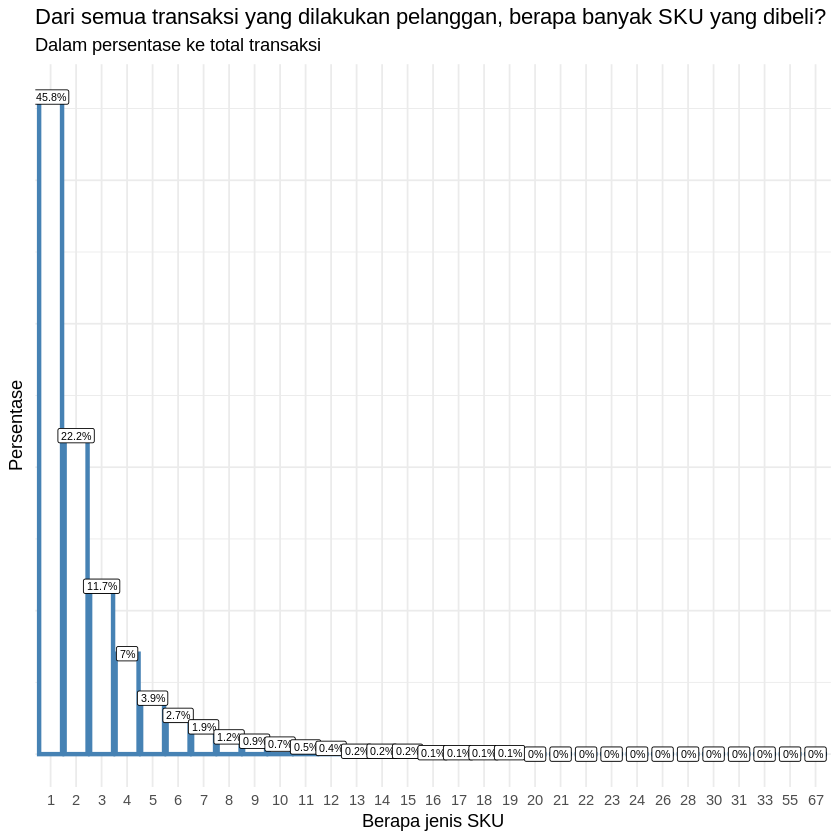

In [ ]:
# @title
data_baru =
  df_all %>% filter(sku!= 'PLAS TIK') %>%
  group_by(id_transaksi) %>%
  summarise(barang = length(sku)) %>%
  ungroup() %>%
  group_by(barang) %>%
  summarise(freq = n()) %>%
  ungroup() %>%
  mutate(percent = freq/sum(freq),
         percent = round(percent*100,1))

data_baru %>%
  ggplot(aes(x=as.factor(barang),y=percent)) +
  geom_col(fill = 'white',
           color = 'steelblue',
           size = 1.25) +
  geom_label(aes(label = paste0(percent,'%')),
            size = 2.25) +
  labs(x = 'Berapa jenis SKU',
       y = 'Persentase',
       title = 'Dari semua transaksi yang dilakukan pelanggan, berapa banyak SKU yang dibeli?',
       subtitle = 'Dalam persentase ke total transaksi') +
  theme_minimal() +
  theme(axis.text.y = element_blank())

Ternyata setelah kita lihat, `45.8%` dari semua transaksi dilakukan dengan hanya membeli `1` jenis `sku` saja. Sedangkan `22.2%` dari semua transaksi dilakukan dengan membeli `2` jenis `sku` saja.

Mayoritas dari semua transaksi (`r paste0(45.8+22.2,'%')`) hanya membeli 1-2 jenis `sku` saja.

__Mengapa informasi ini diperlukan?__

> Dalam membuat produk bundling, diperlukan data kombinasi sku yang dibeli oleh pelanggan dalam jumlah yang cukup.

Oleh karena jumlah data yang ada relatif terbatas, maka kita akan cek kemudian ada berapa banyak paket _bundling_ yang bisa di-_generate_ dari analisa ini.

Untuk lebih jelasnya, silakan dibaca penjelasan mengenai dasar teori analisa ini.

### Dasar Teori

Ada berbagai macam cara untuk bisa melihat kesamaan dari beberapa produk yang dibeli oleh pelanggan. _Umbrella terms_ dari teknik-teknik tersebut disebut dengan analisa _association_.

_Output_ dari analisa ini disebut dengan _rules_ yaitu:

> predict the occurrence of an item based on the occurrences of other items in the transaction.

Penjelasan yang lebih mudah lagi adalah:

> _if this, then that..._

Perlu diingat bahwa _rules_ dibangun berdasarkan data transaksi yang ada.

### _a little bit of math_

Misalkan:

- Item produk saya tuliskan sebagai: $I = \{i_1,i_2,i_3,...,i_n\}$
- Transaksi saya tuliskan sebagai: $T = \{t_1,t_2,t_3,...,t_n\}$
- Setiap transaksi di $T$ memiliki _unique transaction id_ dan berisi item produk di $I$.

Definisi resmi dari _rules_ adalah:

> _if a user buys an item in the item set on the left hand side, then the user will likely buy the item on the right hand side too_

Secara matematis dinotasikan sebagai: $X \implies Y$, dimana $X,Y	\subseteq I$

- Setiap _rules_ berisi dua himpunan item produk, yakni $X$ dan $Y$.
- Sebagai contoh, _rules_ akan ditulis sebagai berikut: $\{i_1,i_2\} \implies \{i_k\}$.
- Bagian kiri, yakni himpunan produk $(X)$ ditulis __lhs__.
- Bagian kanan, yakni himpunan produk $(Y)$ ditulis __rhs__.

### Contoh Sederhana

Misalkan saya memiliki data transaksi sebagai berikut:

In [ ]:
# @title
data.frame(
  transaction_id = c(1:5),
  items = c('Milk, Bread',
            'Butter',
            'Beer, Diapers',
            'Milk, Bread, Butter',
            'Bread')
  )

transaction_id,items
<int>,<chr>
1,"Milk, Bread"
2,Butter
3,"Beer, Diapers"
4,"Milk, Bread, Butter"
5,Bread


Maka, himpunan item produk yang adalah sebagai berikut: $I=\{Milk,Bread,Butter,Beer,Diaper\}$.

Sedangkan himpunan transaksi adalah sebagai berikut: $T=\{1,2,3,4,5\}$.

Salah satu contoh _rules_ dari data di atas adalah:

_If a consumer buys butter and bread, then they are also likely to buy milk_. Dinotasikan: $\{Butter,Bread\} \implies \{Milk\}$

Catatan Penting:

> Implication means co-occurrence, not causality!

### ___Association Rules Parameter___

Dalam analisa asosiasi, ada tiga parameter utama yang akan kita hitung, yakni:

#### ___Support___

Definisi:

> Support is an indication of how frequently the itemset appears in the dataset.

Notasi: $supp(X)=\frac{|\{t \in T,X \subseteq T\}|}{|T|}$

Contoh:

Jika $X=\{Beer,Diapers\}$, maka memiliki nilai _support_ sebesar `20%` (produk _beer_ dan _diapers_ bersamaan ditemukan pada `1` dari `5` transaksi)

#### ___Confidence___

Definisi:

> Confidence is an indication of how often the rule has been found to be true.

_Confidence_ dari suatu _rule_ $X \implies Y$ dari data transaksi dihitung dari proporsi transaksi yang mengandung $X$ dan juga mengandung $Y$.

Notasi: $conf(X \implies Y)=\frac{supp(X \cup Y)}{supp(X)}$

_Confidence_ bisa dilihat sebagai _conditional probability_ $P(E_Y|E_X)$, yakni peluang mendapatkan __rhs__ pada saat transaksi mengandung __lhs__.

Contoh:

Rule $\{Bread,Butter\} \implies \{milk\}$ memiliki nilai _confidence_ = `100%`.

Cara hitungnya:

$$conf(\{Bread,Butter\} \implies \{milk\})=\frac{supp(X \cup Y)}{supp(X)}$$

$$conf(\{Bread,Butter\} \implies \{milk\})=\frac{supp(\{Bread,Butter,Milk\})}{supp(\{Milk\})}$$

$$conf(\{Bread,Butter\} \implies \{milk\})=\frac{1/5}{1/5}=100\%$$

Kesimpulan dari contoh: setiap ada transaksi yang mengandung _itemset_ $\{Bread,Butter\}$ pasti selalu mengandung _itemset_ $\{milk\}$.


#### ___Lift___

Definisi:

> Rasio yang menunjukan apakah _itemset_ $X$ dan _itemset_ $Y$ independen atau tidak.

Jika:

1. $lift<100\%$, artinya __lhs__ dan __rhs__ saling meniadakan (barang substitusi). Peluang _upselling_ dengan menawarkan barang substitusi termahal.
2. $lift=100\%$, artinya __lhs__ dan __rhs__ independen (saling bebas).
3. $lift>100\%$, artinya __lhs__ dan __rhs__ saling bergantung.

Notasi: $lift(X \implies Y)=\frac{supp(X \cup Y)}{supp(X)*supp(Y)}$

Contoh:

Rule $\{Milk, Bread\} \implies \{Butter\}$ memiliki nilai _lift_ = `125%`

Cara hitungnya:

$$lift(\{Milk, Bread\} \implies \{Butter\})=\frac{supp(X \cup Y)}{supp(X)*supp(Y)}$$

$$lift(\{Milk, Bread\} \implies \{Butter\})=\frac{supp(\{Milk, Bread,Butter\})}{supp(\{Milk, Bread\})*supp(\{Butter\})}$$

$$lift(\{Milk, Bread\} \implies \{Butter\})=\frac{1/5}{2/5*2/5}=125\%$$

Kesimpulan dari contoh: _itemset_ __lhs__ dan __rhs__ saling bergantung.

### Menentukan Produk _Bundling_

Setelah membaca penjelasan di atas, maka untuk menentukan produk apa saja yang akan di-_bundling_, kita akan melihat setidaknya dua parameter utama, yakni: _confidence_ dan _lift_ dengan syarat sebagai berikut:

1. _Support_ harus relatif besar, artinya kemunculan _rules_ ini cukup banyak terjadi. Pada hasil _output_, nanti kita bisa melihat parameter bernama _count_.
1. _Confidence_ tinggi, misalkan $>80\%$.
2. _Lift_ harus $>100\%$


### Proses Perhitungan

Untuk menghitung semua kombinasi _rules_ beserta parameternya, saya akan gunakan algoritma apriori.


In [ ]:
df_all %>%
  filter(sku!= 'PLAS TIK') %>%
  mutate(sku = gsub("[^[:alnum:] ]", "", sku)) %>%
  group_by(id_transaksi) %>%
  summarise(freq = n(),
            barang = stringr::str_c(sku,collapse = ',')) %>%
  ungroup() %>%
  select(barang) %>%
  write.csv('trans.csv',quote = FALSE, row.names = TRUE)

tr = read.transactions('trans.csv',format = 'basket',sep=',')
rules <- apriori(tr, parameter = list(supp=0.0005, conf=0.4))
rules <- sort(rules, by=c('count','confidence'), decreasing = TRUE)

summary(rules)


Warning message in asMethod(object):
“removing duplicated items in transactions”


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.4    0.1    1 none FALSE            TRUE       5   5e-04      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 6 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[16297 item(s), 12868 transaction(s)] done [0.03s].
sorting and recoding items ... [1167 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.01s].
writing ... [36 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


set of 36 rules

rule length distribution (lhs + rhs):sizes
 2  3  4 
19 15  2 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   2.000   2.000   2.528   3.000   4.000 

summary of quality measures:
    support            confidence        coverage             lift       
 Min.   :0.0005440   Min.   :0.4000   Min.   :0.001088   Min.   : 15.23  
 1st Qu.:0.0006994   1st Qu.:0.4500   1st Qu.:0.001477   1st Qu.: 20.34  
 Median :0.0010103   Median :0.4711   Median :0.001865   Median : 27.27  
 Mean   :0.0015629   Mean   :0.4973   Mean   :0.003266   Mean   : 64.37  
 3rd Qu.:0.0018068   3rd Qu.:0.5281   3rd Qu.:0.003478   3rd Qu.: 91.22  
 Max.   :0.0080044   Max.   :0.7200   Max.   :0.019428   Max.   :211.82  
     count       
 Min.   :  7.00  
 1st Qu.:  9.00  
 Median : 13.00  
 Mean   : 20.11  
 3rd Qu.: 23.25  
 Max.   :103.00  

mining info:
 data ntransactions support confidence
   tr         12868   5e-04        0.4
                                                       

### _Detailed Rules_

Mari kita lihat detail semua _rules_ yang ada sebagai berikut:

In [ ]:
write(rules,file = "association_rules.csv",sep = ",",quote = TRUE,row.names = FALSE)
hasil = read.csv("association_rules.csv")
hasil

rules,support,confidence,coverage,lift,count
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
{INDOMIE SOTO MIE 70 GR} => {INDOMIE GORENG 85G},0.0080043519,0.4120000,0.019428039,15.23453,103
{INDOMIE AYAM BAWANG 69 GR} => {INDOMIE GORENG 85G},0.0056729873,0.5140845,0.011035126,19.00931,73
{INDOMIE KARI AYAM BAWANG GORENG 70 GR} => {INDOMIE GORENG 85G},0.0052067143,0.4685315,0.011112838,17.32489,67
{INDOMIE AYAM SPECIAL 56 GR} => {INDOMIE GORENG 85G},0.0024090768,0.4626866,0.005206714,17.10877,31
"{INDOMIE KARI AYAM BAWANG GORENG 70 GR,INDOMIE SOTO MIE 70 GR} => {INDOMIE GORENG 85G}",0.0022536525,0.5087719,0.004429593,18.81287,29
"{INDOMIE GORENG 85G,INDOMIE KARI AYAM BAWANG GORENG 70 GR} => {INDOMIE SOTO MIE 70 GR}",0.0022536525,0.4328358,0.005206714,22.27893,29
{TRANSAKSI PLN 2} => {TRANSAKSI PLN},0.0020205160,0.6190476,0.003263910,75.86576,26
{BIHUNKU KUAH AYAM BAWANG SPESIAL 55 GR} => {BIHUNKU SOTO SPESIAL 55GR},0.0018650917,0.4897959,0.003807896,110.57358,24
{BIHUNKU SOTO SPESIAL 55GR} => {BIHUNKU KUAH AYAM BAWANG SPESIAL 55 GR},0.0018650917,0.4210526,0.004429593,110.57358,24


Angka $support$ akan berbanding lurus dengan $count$, oleh karena itu bisa dipilih salah satu saja untuk menentukan _rules_ mana yang __banyak__ terjadi.

Dari _rules_ yang ada, kita bisa lakukan beberapa analisa terkait nilai $lift$.


### Barang Substitusi

Ternyata kita dapatkan bahwa beberapa _rules_ memiliki nilai $lift \leq 100\%$, yakni:


In [ ]:
hasil %>% filter(lift<100) %>% select(rules,count,confidence)

rules,count,confidence
<chr>,<int>,<dbl>
{INDOMIE SOTO MIE 70 GR} => {INDOMIE GORENG 85G},103,0.4120000
{INDOMIE AYAM BAWANG 69 GR} => {INDOMIE GORENG 85G},73,0.5140845
{INDOMIE KARI AYAM BAWANG GORENG 70 GR} => {INDOMIE GORENG 85G},67,0.4685315
{INDOMIE AYAM SPECIAL 56 GR} => {INDOMIE GORENG 85G},31,0.4626866
"{INDOMIE KARI AYAM BAWANG GORENG 70 GR,INDOMIE SOTO MIE 70 GR} => {INDOMIE GORENG 85G}",29,0.5087719
"{INDOMIE GORENG 85G,INDOMIE KARI AYAM BAWANG GORENG 70 GR} => {INDOMIE SOTO MIE 70 GR}",29,0.4328358
{TRANSAKSI PLN 2} => {TRANSAKSI PLN},26,0.6190476
"{INDOMIE AYAM BAWANG 69 GR,INDOMIE SOTO MIE 70 GR} => {INDOMIE GORENG 85G}",23,0.4893617
{LEMONILO MIE KUAH KARI AYAM} => {LEMONILO MIE INSTANT GORENG BUBUK BAYAM},20,0.4545455


Berdasarkan informasi ini, mungkin kita bisa menyusun strategi jika `sku`'s yang ada pada _rules_ tersebut sedang habis atau _limited stock_. Terutama pada _rules_ dengan $count$ yang __banyak__.

### _Bundling_ Produk

Sekarang kita akan mengambil _rules_ dengan nilai $lift \geq 100\%$, yakni:

In [ ]:
hasil %>% filter(lift>100) %>% select(rules,count,confidence,lift)


rules,count,confidence,lift
<chr>,<int>,<dbl>,<dbl>
{BIHUNKU KUAH AYAM BAWANG SPESIAL 55 GR} => {BIHUNKU SOTO SPESIAL 55GR},24,0.4897959,110.5736
{BIHUNKU SOTO SPESIAL 55GR} => {BIHUNKU KUAH AYAM BAWANG SPESIAL 55 GR},24,0.4210526,110.5736
{LA FONTE SAUS PASTA BOLOGNESEPOCH315GR} => {LA FONTE LP SPAGHETI 450 GR},12,0.4615385,164.9744
{BIHUNKU BIHUN GORENG SPECIAL 60 GR} => {BIHUNKU KUAH AYAM BAWANG SPESIAL 55 GR},11,0.5000000,131.3061
{MADU STICK ANGGUR 15G} => {MADU STICK JERUK 15G},11,0.4074074,145.6255
{MADU STICK ORIGINAL 15 GRAM} => {MADU STICK JERUK 15G},10,0.4166667,148.9352
{MOLTO PEWANGI PINK REFILL 450 ML} => {DAIA DETERGENT FLORAL EKTRA BUNGA 305GR},8,0.4444444,211.8189
{TAOKAENOI BIG SHEET HOT SPICY 4 GR} => {TAO KAE NOI CRISPY BIG SHEETCLASSIC4GR},8,0.4210526,174.7776
{ROJO LELE BERAS 4 KG 5 LITER} => {FOOD STASION GULA KRISTAL PUTIH 1 KG},7,0.4666667,171.5733


Didapatkan ada `9` buah _rules_ yang bisa dijadikan calon _bundling_ produk. Namun, ada beberapa catatan terkait temuan ini:

1. $count$ dari _rules_ yang ada tergolong kecil. Artinya _real cases_ dari _rules_ ini relatif jarang terjadi.
2. $confidence$ yang ada juga masih di $\leq 50\%$.

Berikut visualisasi dari _rules_ tersebut:

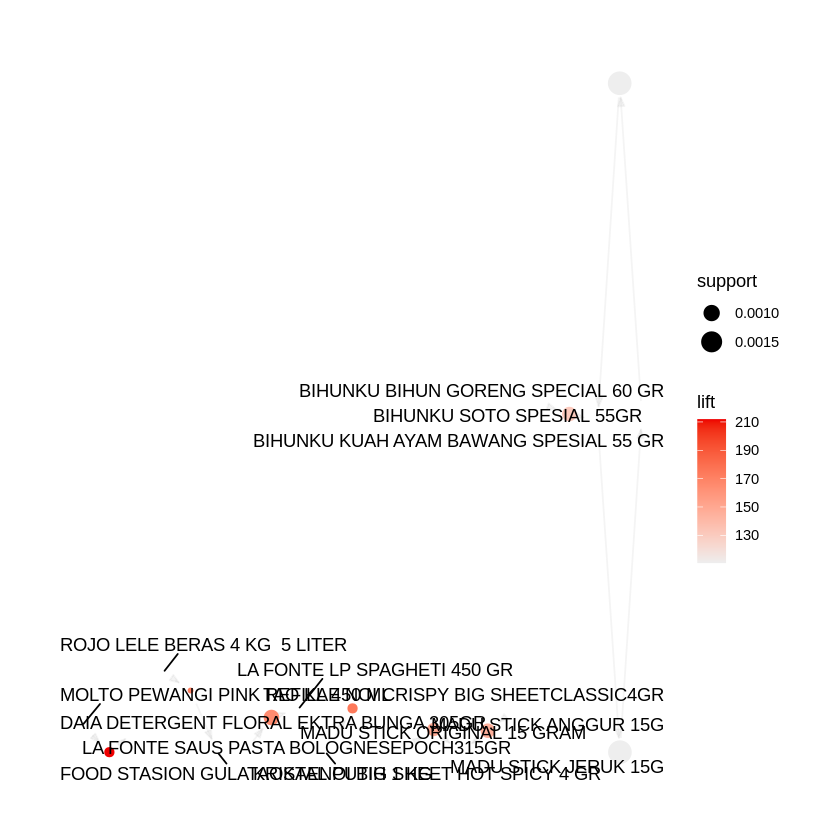

In [ ]:
rules <- sort(rules, by=c('lift'), decreasing = TRUE)
plot(rules[1:9],method = "graph")